In [20]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 1. Load Dataset

In [2]:
df_raw1 = pd.read_csv('./data/jeju_data_ver1/201901-202003.csv')
df_raw2 = pd.read_csv('./data/jeju_data_ver1/202004.csv')

In [3]:
df = pd.concat([df_raw1, df_raw2], axis=0)

# Data Preprocessing

In [4]:
df.fillna('세종시', inplace=True)

In [5]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [6]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [7]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [8]:
df.drop(['CARD_CCG_NM', 'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD'], axis=1, inplace=True)

# 업종 카운트 데이터 생성

In [9]:
# 업종 카운트 데이터
tmp = df.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM', 'FLC', 'year', 'month']).count()
tmp = tmp[['CNT']].rename(columns={'CNT':'std_cnt'})

In [10]:
# 데이터 정제
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'FLC', 'year', 'month']

df = df.groupby(columns).sum().reset_index(drop=False)
df = df.merge(tmp, how='left', on=columns)
# df = df.merge(flcs, how='left', on=columns)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,FLC,year,month,CSTMR_CNT,AMT,CNT,std_cnt
0,강원,건강보조식품 소매업,1,2019,1,4,311200,4,1
1,강원,건강보조식품 소매업,1,2019,2,7,1517000,8,2
2,강원,건강보조식품 소매업,1,2019,3,16,982750,17,3
3,강원,건강보조식품 소매업,1,2019,4,4,266000,4,1
4,강원,건강보조식품 소매업,1,2019,5,13,1057200,15,3


In [11]:
# 단골 지수
def regular(x, y):
    if x == 0:
        x += 1
    return y / x

df['regular_power'] = df.apply(lambda x: regular(x['CSTMR_CNT'], x['CNT']), axis=1)

In [12]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [13]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [14]:
df['CV'] = 0
df.loc[(df['year']==2020) & (df['month']==1), 'CV'] = 1
df.loc[(df['year']==2020) & (df['month']==2), 'CV'] = 2
df.loc[(df['year']==2020) & (df['month']==3), 'CV'] = 3

In [15]:
df['FLC'] = df['FLC'].astype('object')
df['month'] = df['month'].astype('object')

In [16]:
df

,CARD_SIDO_NM,STD_CLSS_NM,FLC,year,month,CSTMR_CNT,AMT,CNT,std_cnt,regular_power,Season,CV
0,강원,건강보조식품 소매업,1,2019,1,4,311200,4,1,1.000000,Winter,0
1,강원,건강보조식품 소매업,1,2019,2,7,1517000,8,2,1.142857,Winter,0
2,강원,건강보조식품 소매업,1,2019,3,16,982750,17,3,1.062500,Spring,0
3,강원,건강보조식품 소매업,1,2019,4,4,266000,4,1,1.000000,Spring,0
4,강원,건강보조식품 소매업,1,2019,5,13,1057200,15,3,1.153846,Spring,0
...,...,...,...,...,...,...,...,...,...,...,...,...
47858,충북,휴양콘도 운영업,5,2019,12,128,9446100,190,21,1.484375,Winter,0
47859,충북,휴양콘도 운영업,5,2020,1,149,12968610,233,21,1.563758,Winter,1
47860,충북,휴양콘도 운영업,5,2020,2,61,3895100,97,7,1.590164,Winter,2
47861,충북,휴양콘도 운영업,5,2020,3,15,1347800,19,5,1.266667,Spring,3


In [17]:
df['FLC'] = df['FLC'].astype('object')
df['month'] = df['month'].astype('object')

In [21]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [22]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47863 entries, 0 to 47862
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CARD_SIDO_NM   47863 non-null  int32  
 1   STD_CLSS_NM    47863 non-null  int32  
 2   FLC            47863 non-null  int32  
 3   year           47863 non-null  int64  
 4   month          47863 non-null  int32  
 5   CSTMR_CNT      47863 non-null  int64  
 6   AMT            47863 non-null  int64  
 7   CNT            47863 non-null  int64  
 8   std_cnt        47863 non-null  int64  
 9   regular_power  47863 non-null  float64
 10  Season         47863 non-null  int32  
 11  CV             47863 non-null  int64  
dtypes: float64(1), int32(5), int64(6)
memory usage: 3.8 MB


In [23]:
df.CARD_SIDO_NM.unique()

array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산',
       '인천', '전남', '전북', '제주', '충남', '충북'], dtype=object)

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [172]:
# feature, target 설정
x = df_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
y = np.log1p(df_num['AMT'])

# Preprocessing

In [95]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [96]:
X = df_num.drop(['AMT'], axis=1)
y = df_num[['month', 'AMT']]
y['AMT'] = np.log1p(df_num['AMT'])
X_train, X_test, y_train, y_test = X[X['month']!=4], X[X['month']==4], y[y['month']!=4]['AMT'], y[y['month']==4]['AMT']

In [97]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
X_train_scaler = scaler.fit(X_train)
X_test_scaler = scaler.fit(X_test)


# 스케일링 적용
X_train = X_train_scaler.transform(X_train)
X_test = X_test_scaler.transform(X_test)

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# LSTM Model

In [98]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)
print("ytrain set : ", y_train.shape)
print("ytest set : ", y_test.shape)

train set :  (44826, 11)
test set :  (3037, 11)
ytrain set :  (44826, 1)
ytest set :  (3037, 1)


In [99]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [100]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [101]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [102]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([44826, 1, 11])
X_test : torch.Size([3037, 1, 11])
y_train : torch.Size([44826, 1, 1])
y_test : torch.Size([3037, 1, 1])


# Building a Model

In [118]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):

        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)

        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [119]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [120]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [121]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=4
n_layers=4
lr=0.01
num_epochs=3

In [122]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [124]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 351.1512 test loss: 352.5625


In [104]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

NameError: name 'train_hist' is not defined

# Predicting daily cases

In [41]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [42]:
preds

[0.10553672909736633,
 0.10768473148345947,
 0.10748264193534851,
 0.10582581162452698,
 0.10279121994972229,
 0.10070548951625824,
 0.10047805309295654,
 0.1001516729593277,
 0.09886464476585388,
 0.09639619290828705,
 0.09412139654159546,
 0.09357571601867676,
 0.09617890417575836,
 0.10084402561187744]

In [43]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [44]:
pred_values

array([[6.75435066],
       [6.89182281],
       [6.87888908],
       [6.77285194],
       [6.57863808],
       [6.44515133],
       [6.4305954 ],
       [6.40970707],
       [6.32733727],
       [6.16935635],
       [6.02376938],
       [5.98884583],
       [6.15544987],
       [6.45401764]])

In [45]:
# # 예측값 반올림
# import math

# pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
# pred_values_ceiled

In [46]:
pred_values_ceiled  = list(pred_values.flatten())

In [47]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [48]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [49]:
# score_table['True_1'] = score_table['True'].diff()
# score_table['Pred_1'] = score_table['Pred'].diff()
# score_table['Pred_1'].iloc[0] = 0
# score_table['True_1'].iloc[0] = 0

In [50]:
score_table['pred_1'] = 6.33151302992317
score_table['mean'] = (score_table['Pred'] + score_table['pred_1'])/2

In [51]:
score_table

,True,Pred,pred_1,mean
0,6.0,6.754351,6.331513,6.542932
1,4.0,6.891823,6.331513,6.611668
2,2.0,6.878889,6.331513,6.605201
3,4.0,6.772852,6.331513,6.552182
4,10.0,6.578638,6.331513,6.455076
5,7.0,6.445151,6.331513,6.388332
6,12.0,6.430595,6.331513,6.381054
7,5.0,6.409707,6.331513,6.370610
8,4.0,6.327337,6.331513,6.329425
9,8.0,6.169356,6.331513,6.250435


In [58]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [59]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 9.252733576414487, RMSE : 3.0418306291466144, SCORE : 81.67775529422873


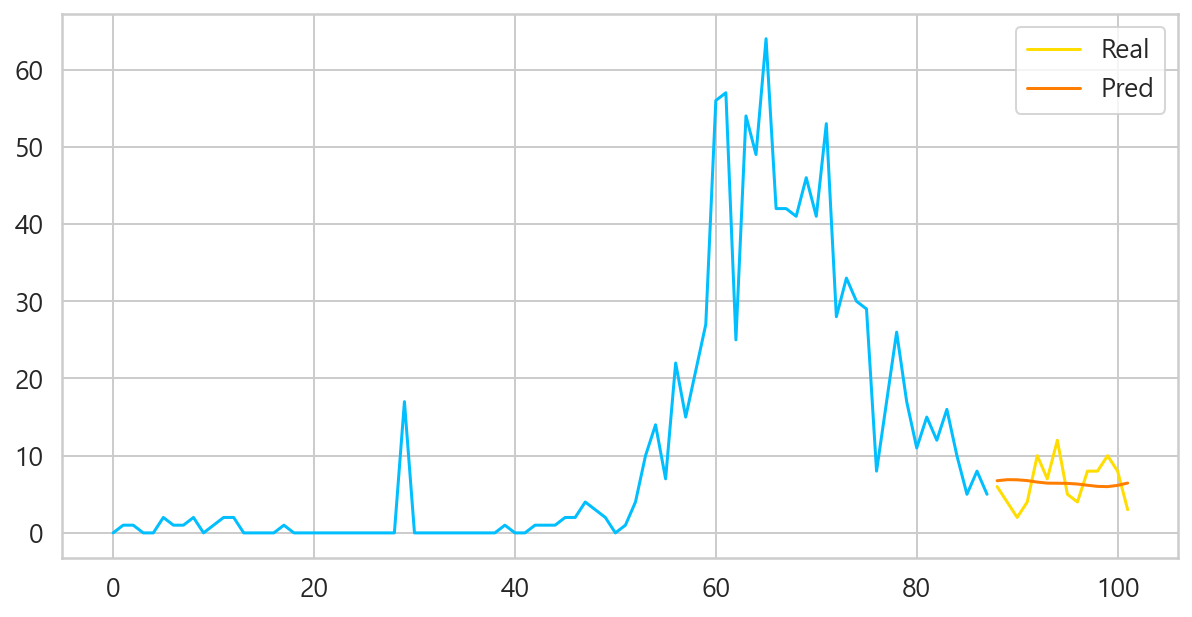

In [60]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [64]:
# 모델 저장
#PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [65]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [72]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['TARGET']

In [73]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [74]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [75]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 86)
y_all :  (102,)


In [76]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [160]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

Epoch 0 train loss: 0.07365627586841583
Epoch 10 train loss: 0.06583075225353241


KeyboardInterrupt: 

# Predicting future cases

In [77]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [78]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [79]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[7, 7, 6, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3]

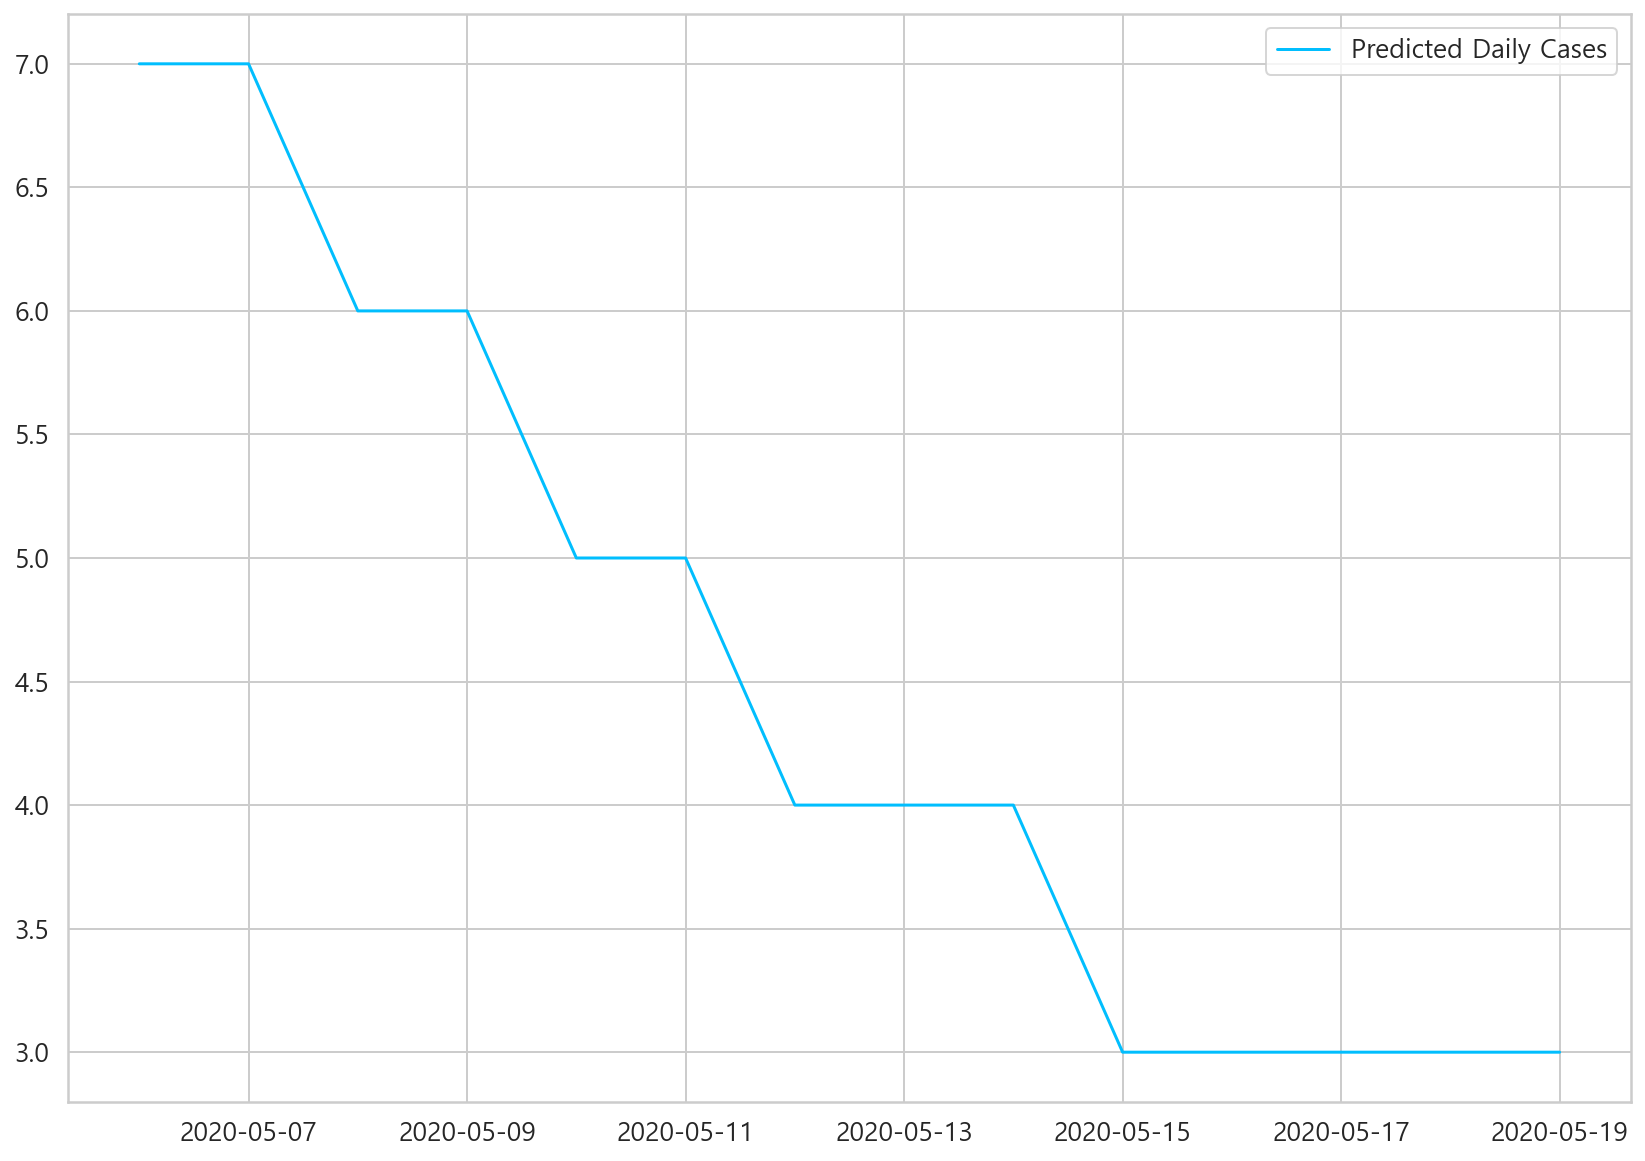

In [80]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [81]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [82]:
preds_

,0
2020-05-06,7
2020-05-07,7
2020-05-08,6
2020-05-09,6
2020-05-10,5
2020-05-11,5
2020-05-12,4
2020-05-13,4
2020-05-14,4
2020-05-15,3


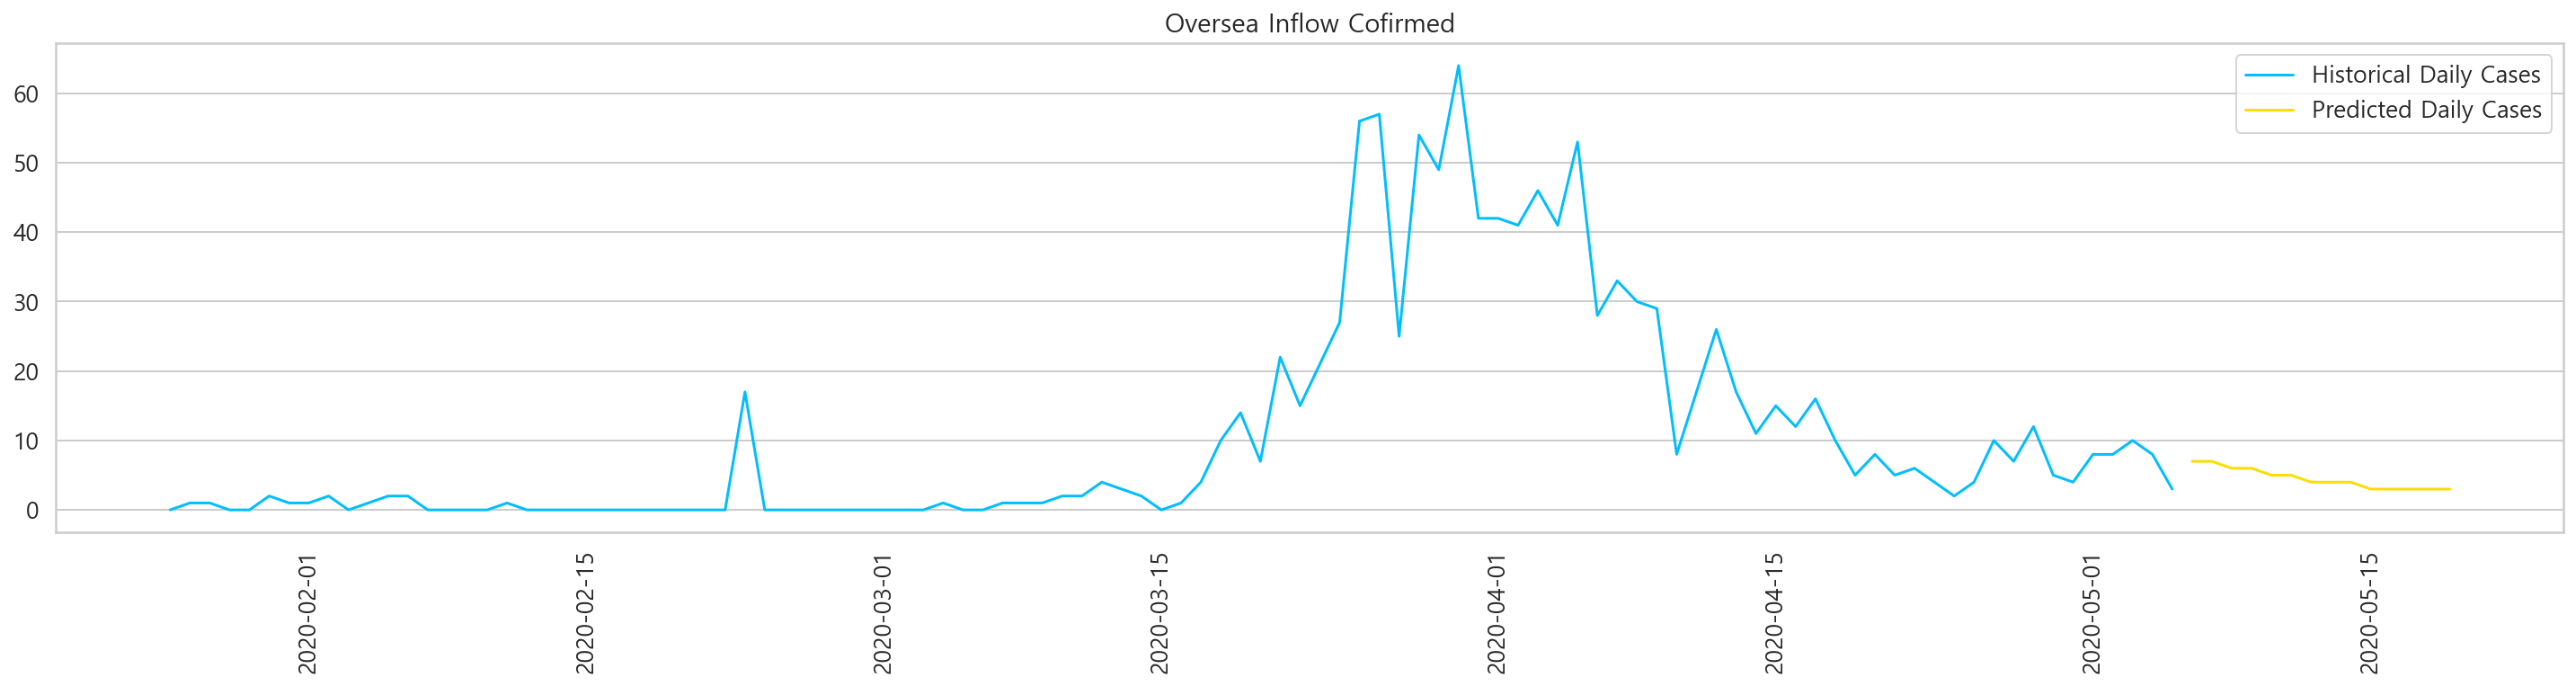

In [83]:
plt.figure(figsize=(25,5))
plt.plot(df['TARGET'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();